# 🌲 Capítulo 6 – Detección de Anomalías con Isolation Forest

En el quinto capítulo se presentará el algoritmo Isolation Forest, una técnica no supervisada de detección de anomalías que se fundamenta en principios estadísticos y estructurales. Su principal fortaleza radica en que no requiere datos etiquetados ni un entrenamiento supervisado, lo que lo convierte en una opción idónea para contextos como el presente, donde no se dispone de información fiable que distinga entre observaciones normales y anómalas.

Isolation Forest se basa en la idea de que los puntos anómalos, al estar menos integrados en la distribución general de los datos, pueden aislarse más fácilmente a través de divisiones aleatorias del espacio de características. 

---

## 🎯 ¿Por qué Isolation Forest?

La elección de Isolation Forest para la detección de anomalías responde a varios motivos:

- Es un modelo **ligero, interpretable y rápido de entrenar**, ideal para exploración temprana.
- No necesita etiquetas ni conocimiento experto previo.
- Puede aplicarse directamente sobre datos multivariados sin requerir grandes transformaciones.
- Ha sido ampliamente utilizado en entornos industriales y de ingeniería de sistemas, lo que aporta cierta confianza sobre su aplicabilidad.

---

## 🧭 Objetivo de este capítulo

A lo largo del capítulo se presentarán:

- Los fundamentos teóricos de Isolation Forest.
- Su aplicación sobre datos reales extraídos de archivos MDF.
- Dos variantes distintas del modelo, incluyendo ajustes en los métodos de partición.
- Un análisis cualitativo de los resultados y sus limitaciones.

Además, se plantearán estrategias para enriquecer la entrada del modelo con información contextual (como deltas y aceleraciones), y se discutirán sus efectos en la detección.

El capítulo concluirá con una reflexión sobre lo que Isolation Forest puede —y no puede— aportar en un contexto como este, y se introducirá el enfoque del siguiente capítulo: **modelos ocultos de Markov (HMM)** para modelar dependencias temporales.

---

## 🔍 Intuición

Isolation Forest (iForest) se basa en la premisa de que:

> "Las anomalías son más fáciles de aislar que los puntos normales."

A diferencia de otros métodos que perfilan el comportamiento normal de los datos, iForest **aísla los puntos** de forma aleatoria y mide cuán fácil es hacerlo. Las anomalías, al ser menos frecuentes y más distintas, se aíslan en menos pasos.

---

## 🧠 Fundamento Teórico

Isolation Forest construye múltiples **árboles binarios aleatorios** (llamados *iTrees*), donde:

- En cada nodo, se selecciona aleatoriamente:
  - Una característica (feature).
  - Un valor de corte entre el mínimo y máximo de esa característica.
- El árbol se construye **recursivamente** hasta:
  - Aislar un único punto, o
  - Alcanzar una profundidad máxima predefinida.

---

## 📐 Profundidad de Aislamiento

Cada punto es recorrido por todos los árboles. Se mide la **longitud del camino** (profundidad) que se necesita para aislarlo.

- Las **anomalías** se aíslan rápidamente → profundidad baja.
- Los **puntos normales** requieren más divisiones → profundidad alta.

La **profundidad media esperada** $ E(h(x)) $ sobre todos los árboles se convierte en un **score de anomalía**:


$$s(x, n) = 2^{-\frac{E(h(x))}{c(n)}}$$


Donde:

- $ s(x, n) \in [0, 1] $: Score de anomalía.
- $ E(h(x)) $: Profundidad media de aislamiento para el punto $ x $.
- $ c(n) $: Valor esperado de la profundidad promedio en un árbol aleatorio para $ n $ puntos:


$$c(n) = 2H(n - 1) - \frac{2(n - 1)}{n}$$


y $ H(i) $ es el $ i $-ésimo número armónico.

---

## 📊 Interpretación del Score

| Score $ s(x) $ | Interpretación            |
|------------------|----------------------------|
| ≈ 1              | Alta probabilidad de anomalía |
| ≈ 0.5            | Indefinido                 |
| ≈ 0              | Punto normal               |

---

## ⚙️ Parámetros Clave

- **n_estimators**: Número de árboles a construir (típico: 100–256).
- **max_samples**: Número de muestras para construir cada árbol (puede ser una fracción del total).
- **max_depth**: Profundidad máxima del árbol (normalmente log₂(n)).
- **Contamination** (en implementación práctica): Porcentaje estimado de anomalías, usado para establecer un umbral.

---

## ✅ Ventajas

- Eficiente en datasets grandes y de alta dimensión.
- No requiere suposiciones estadísticas sobre los datos.
- No supervisado (no necesita etiquetas).

---

## 🚫 Limitaciones

- El rendimiento puede depender de una buena selección de `max_samples`.
- No captura bien estructuras temporales si no se adaptan las features.
- **Cuando se aplica directamente sobre datos crudos, solo detecta anomalías basadas en valores atípicos individuales o combinaciones inusuales. No suele detectar anomalías que provienen de relaciones anómalas entre variables.**

---

### 🔧 Ejemplo concreto

Supongamos un motor en condiciones normales del que poseemos datos de un rodaje en un llano:

- Cuando las **revoluciones por minuto (RPM)** son bajas (ej. 100 RPM), la **temperatura del refrigerante** también debería ser baja (ej. 40 °C).

Si aparece un punto con:

- RPM = 100  
- Temperatura = 95 °C  

Esta combinación **viola la lógica física esperada**, pero los valores individuales **no son extremos**. Si hay otros puntos similares en el dataset, el algoritmo podría **no detectarlo como anómalo**, porque **estadísticamente no es raro**.

➡️ **Isolation Forest no detecta por sí solo rupturas de relaciones físicas entre variables, a menos que esas combinaciones sean infrecuentes en los datos.**

---

## 🔗 Referencias

Liu, Fei Tony, Kai Ming Ting, and Zhi-Hua Zhou.  
**"Isolation forest."** 2008 Eighth IEEE International Conference on Data Mining. IEEE, 2008.




## 🧪 Validación experimental de Isolation Forest Básico

Para evaluar el rendimiento de nuestro **Isolation Forest implementado desde cero**, seguimos el mismo protocolo definido en PCA:

1. **Partición temporal**: generamos una serie sintética con anomalías inyectadas y dividimos en *train*, *val* y *test*. Unimos **train+val** para la búsqueda de hiperparámetros y reservamos **test** para la evaluación final.
2. **Validación con TSCV**: utilizamos un **Time Series Cross-Validation** con ventanas deslizantes (parámetros `P_train`, `num_windows`, etc.) para respetar la causalidad temporal y evitar *look-ahead*.
3. **Preprocesado consistente**: aplicamos el mismo pipeline de preprocesado (detección/mitigación de outliers con filtro de Hampel, tratamiento estacional si procede y normalización) que en el resto de modelos, para asegurar comparaciones justas.
4. **Búsqueda de hiperparámetros**: realizamos un *grid search* sobre:
   - `n_trees`: número de árboles del bosque.
   - `sample_size`: tamaño de muestra por árbol (valores fijos como 256, fracciones del dataset o usar todos los datos).
   - `contamination`: proporción esperada de anomalías, que se usa para fijar el umbral interno de decisión.
5. **Métricas**: calculamos **precision**, **recall**, **F1**, **ROC-AUC**, **NAB** y **window coverage**. Seleccionamos las 5 mejores configuraciones de validación según **NAB**.
6. **Evaluación final**: reentrenamos las configuraciones *top-5* en **train+val** y medimos en **test**. Para cada configuración mostramos la curva ROC y la visualización de anomalías detectadas frente a anomalías reales en las señales.

> Nota: en esta implementación, el parámetro `contamination` controla el **umbral de decisión** a partir del score de aislamiento. Valores altos hacen que el modelo detecte más anomalías (mayor *recall*, menor *precision*), mientras que valores bajos producen un modelo más conservador. El grid permite encontrar el equilibrio más adecuado para nuestro problema.


In [ ]:
# ==========================
# 0. Imports
# ==========================
import pandas as pd
from utils import generate_synthetic_timeseries
from modelos.IsolationForest import IsolationForest 
from modelos.validation_metrics import (
    precision_metric, recall_metric, f1_metric,
    roc_auc_metric, nab_metric, window_coverage_metric
)
from runner import run_experiment

# ==========================
# 1. Generar datos sintéticos
# ==========================
df_train, df_val, df_test = generate_synthetic_timeseries(
    n=1000, train_ratio=0.4, val_ratio=0.3, anomaly_ratio=0.06, seed=42
)

df_trainval = pd.concat([df_train, df_val], ignore_index=True)
X_trainval, y_trainval = df_trainval[["f1", "f2", "f3"]], df_trainval["anomaly"]
X_test, y_test = df_test[["f1", "f2", "f3"]], df_test["anomaly"]

# ==========================
# 2. Definir métricas
# ==========================
metrics = {
    "precision": precision_metric,
    "recall": recall_metric,
    "f1": f1_metric,
    "roc_auc": roc_auc_metric,
    "nab": nab_metric,
    "window_cov": window_coverage_metric
}

# ==========================
# 3. Definir grid de hiperparámetros
# ==========================
param_grid_if = {
    "n_trees": [100, 200, 300],
    "sample_size": [128, 256, 512],
    "contamination": [0.02, 0.05, 0.1, 0.2],
    "split_selection_random": [True]   
}

# ==========================
# 4. Ejecutar experimento
# ==========================
df_results, top5, df_final = run_experiment(
    model_class=IsolationForest,
    param_grid=param_grid_if,
    X_trainval=X_trainval,
    y_trainval=y_trainval,
    X_test=X_test,
    y_test=y_test,
    metrics=metrics,
    params_cv={"P_train": 0.4, "num_windows": 15},  
    mode="tscv",
    sort_metric="nab",  
    top_k=5,
    plot_results=True,
    df_test=df_test     
)


KeyboardInterrupt: 

## 🔀 Variante de división basada en valores reales

En el experimento anterior se utilizó la política tradicional de división en los nodos del bosque:  
- Se selecciona un atributo al azar.  
- Se escoge un punto de corte de forma **uniforme** entre el mínimo y el máximo de dicha característica.  

Esta estrategia es eficiente, pero puede introducir cortes poco representativos cuando los datos están muy concentrados en determinadas zonas, ya que se fuerzan divisiones en regiones donde no hay observaciones.

Para abordar esta limitación, proponemos una variante en la construcción de los árboles:  
- En lugar de muestrear el punto de corte de forma uniforme en \[min, max\], se selecciona **un valor real de la muestra** para definir la división.  
- De esta manera, cada corte se realiza exactamente en un punto presente en los datos, lo que puede conducir a árboles más ajustados a la distribución real y, en algunos casos, a una mejor capacidad de aislamiento de anomalías sutiles.

En la implementación, esta diferencia está controlada por el parámetro:

- `split_selection_random=True` → política clásica (min–max).  
- `split_selection_random=False` → política basada en valores reales de la muestra.  

A continuación repetiremos la validación experimental empleando esta segunda variante, manteniendo el resto del pipeline idéntico, para comparar sus resultados con la versión tradicional.


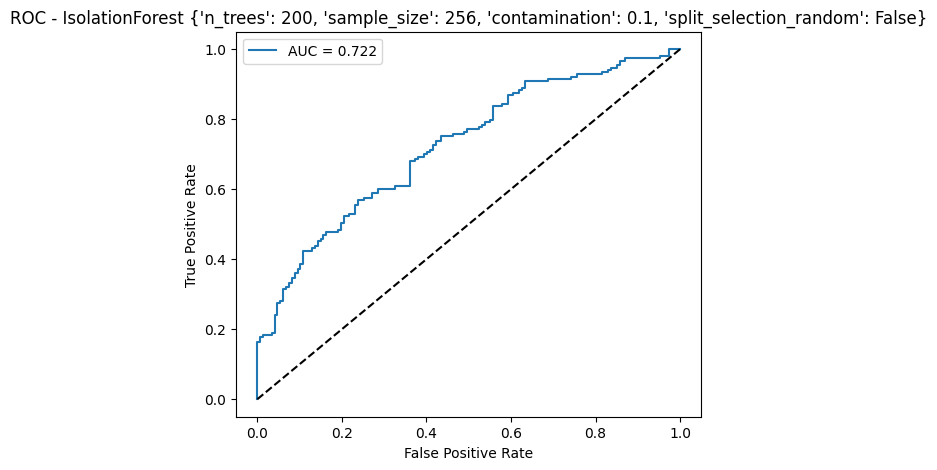

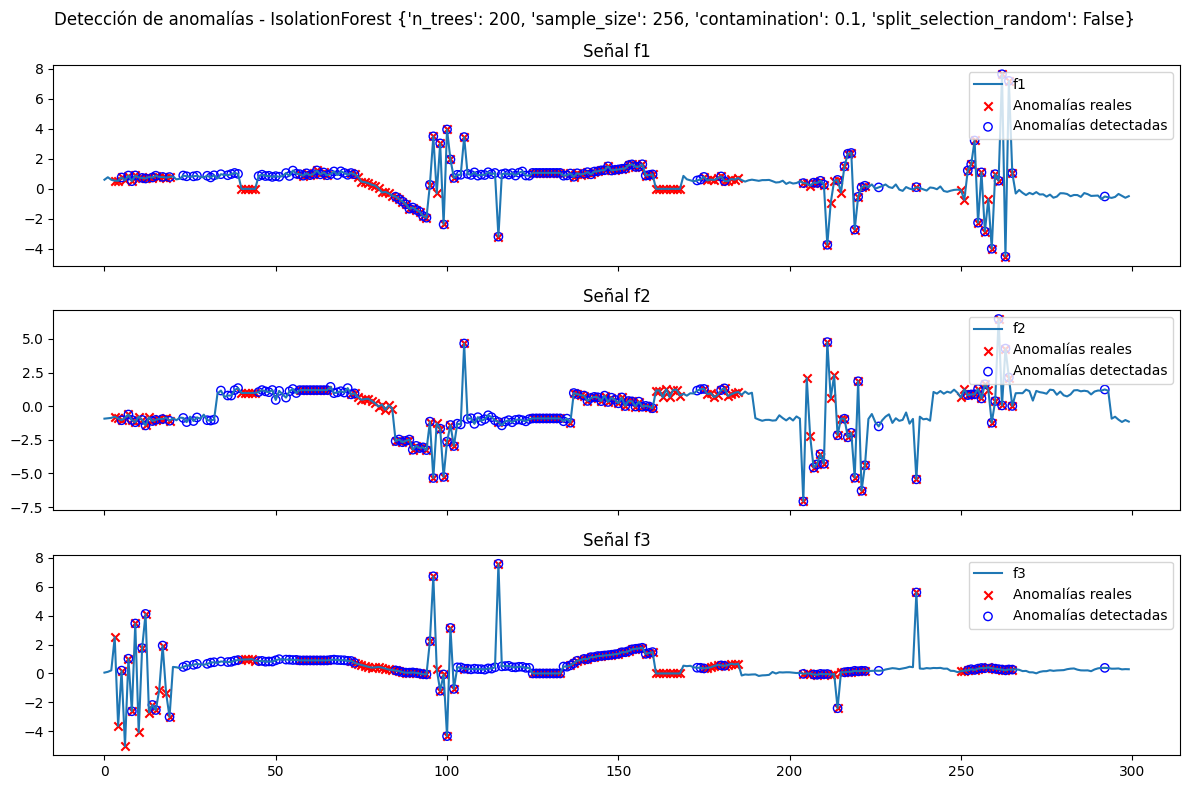

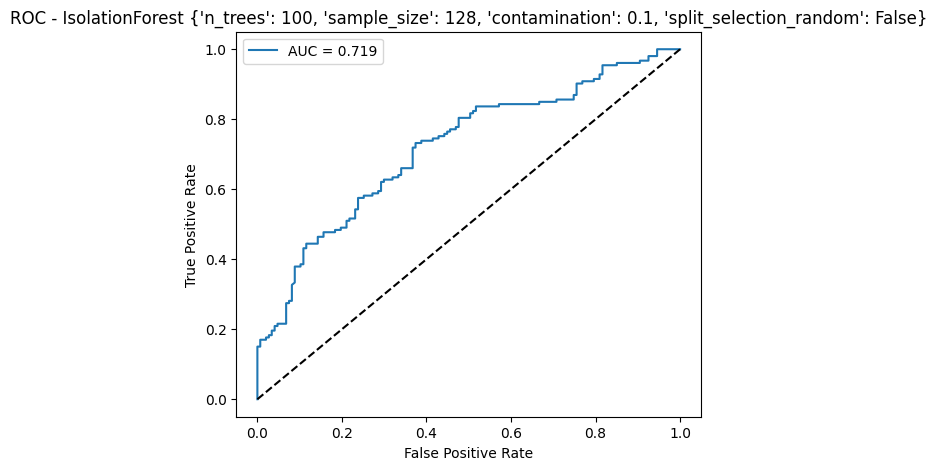

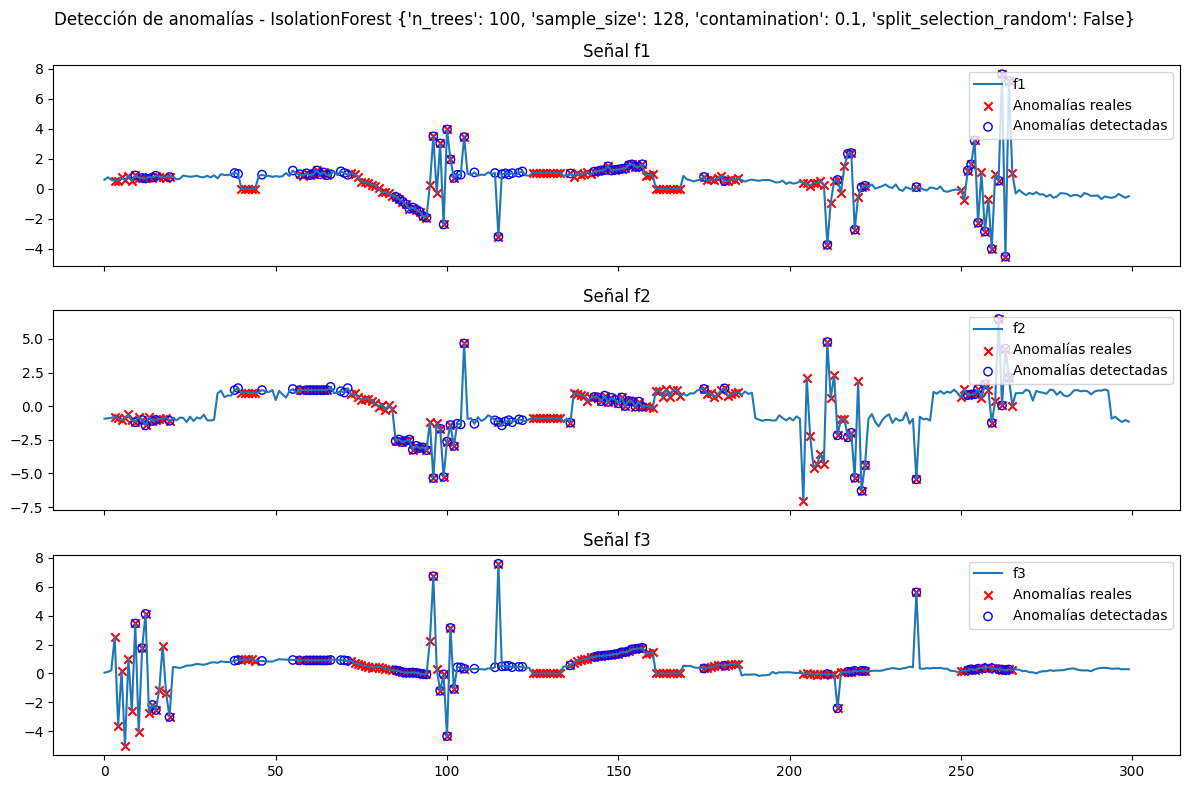

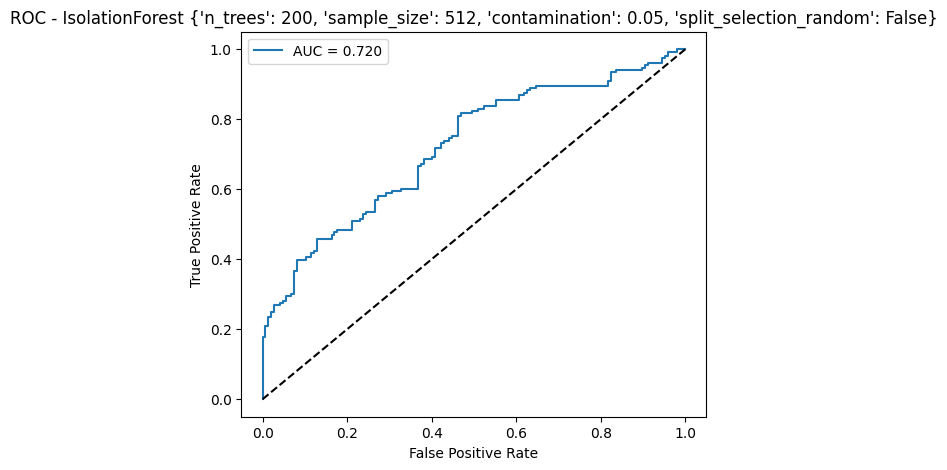

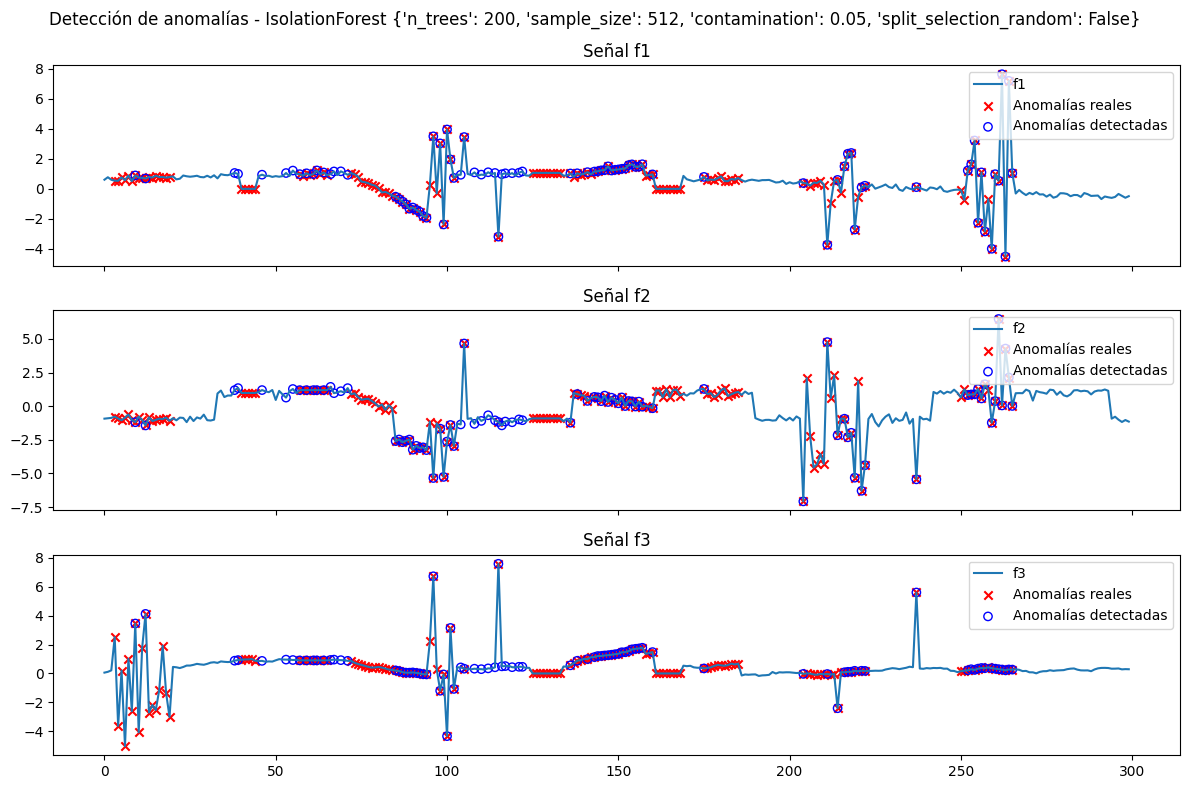

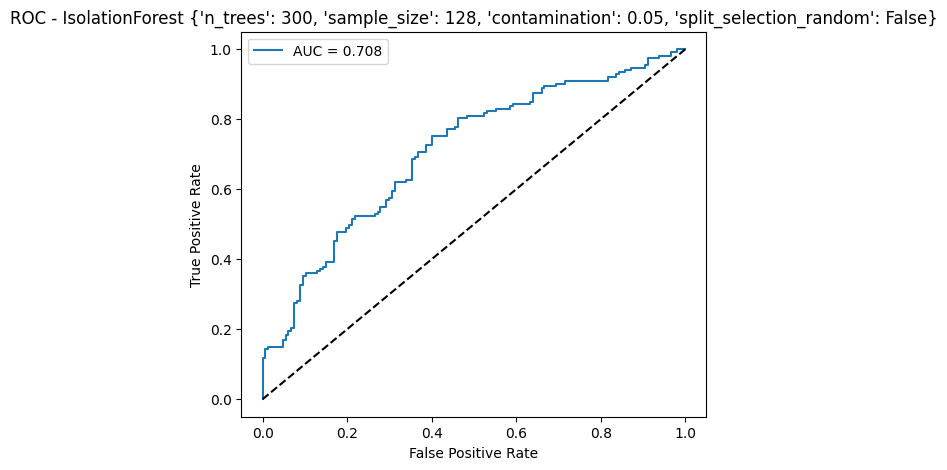

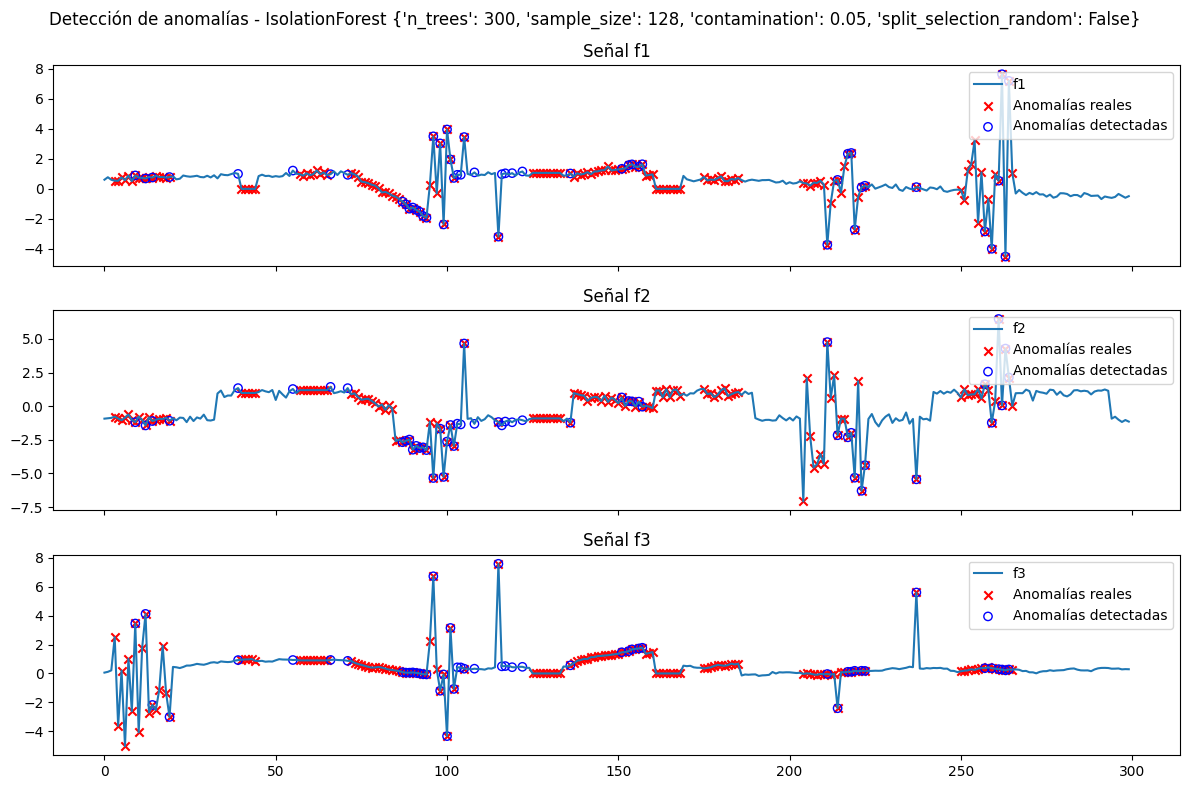

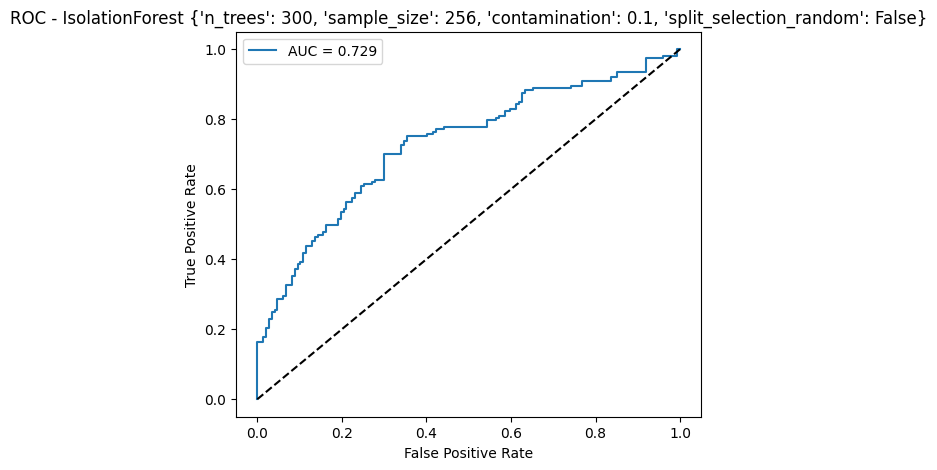

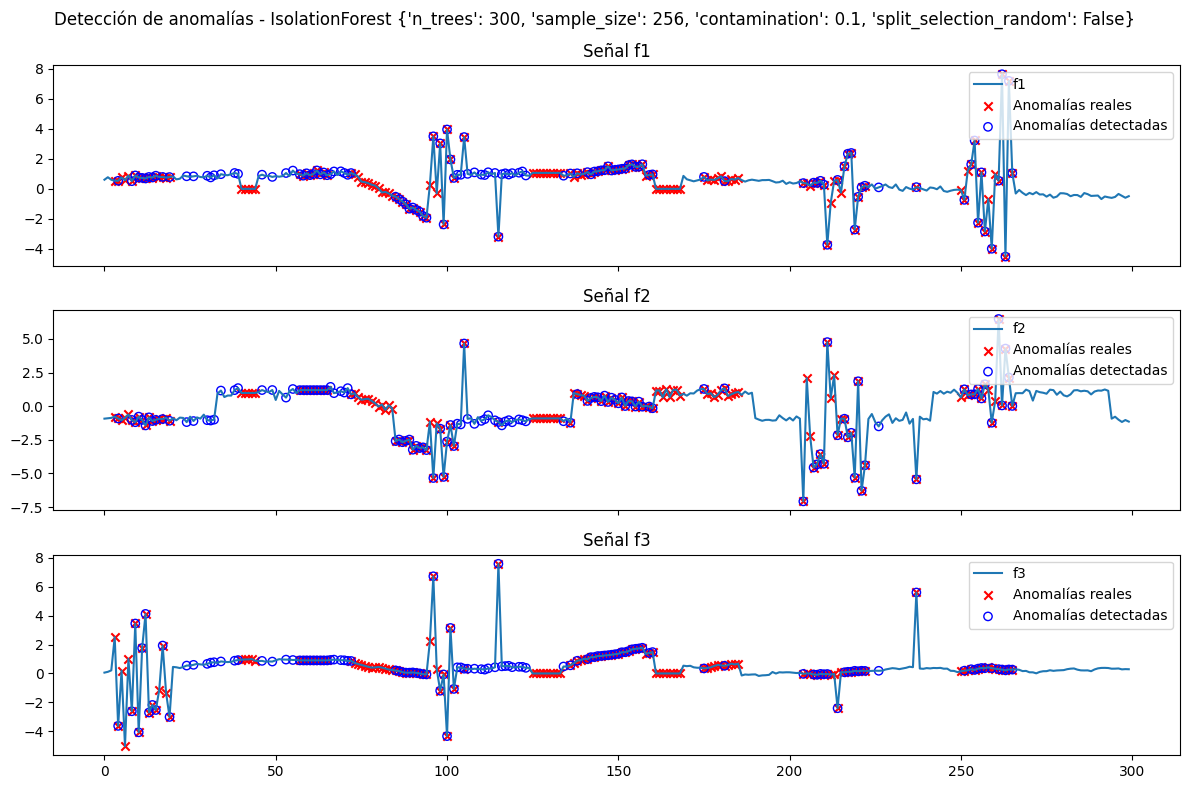

Resultados de validación (grid search en train+val):


,precision,recall,f1,roc_auc,nab,window_cov,n_trees,sample_size,contamination,split_selection_random
0,0.484,0.373,0.387,0.850,0.560,0.379,100,128,0.02,False
1,0.547,0.436,0.445,0.839,0.591,0.442,100,128,0.05,False
2,0.560,0.522,0.501,0.828,0.637,0.531,100,128,0.10,False
3,0.511,0.610,0.522,0.858,0.589,0.614,100,128,0.20,False
4,0.491,0.274,0.313,0.837,0.569,0.298,100,256,0.02,False
5,0.545,0.473,0.484,0.855,0.605,0.474,100,256,0.05,False
6,0.513,0.559,0.495,0.846,0.611,0.558,100,256,0.10,False
7,0.482,0.631,0.513,0.839,0.563,0.635,100,256,0.20,False
8,0.477,0.359,0.359,0.832,0.528,0.360,100,512,0.02,False
9,0.605,0.520,0.522,0.874,0.612,0.519,100,512,0.05,False


Top 5 configuraciones (ordenadas por nab en validación):


,precision,recall,f1,roc_auc,nab,window_cov,n_trees,sample_size,contamination,split_selection_random
18,0.560556,0.551732,0.526837,0.854306,0.648515,0.550960,200,256,0.10,False
2,0.560016,0.521768,0.500628,0.828071,0.636778,0.530839,100,128,0.10,False
21,0.607609,0.500595,0.514226,0.842153,0.635325,0.501811,200,512,0.05,False
25,0.608658,0.441616,0.444904,0.856886,0.629758,0.444939,300,128,0.05,False
30,0.513263,0.572230,0.507923,0.850136,0.628517,0.578434,300,256,0.10,False


Resultados finales en TEST (top-5 configs):


,n_trees,sample_size,contamination,split_selection_random,precision,recall,f1,roc_auc,nab,window_cov
0,200,256,0.10,False,0.654,0.680,0.667,0.722,0.943,0.729
1,100,128,0.10,False,0.791,0.444,0.569,0.719,0.975,0.535
2,200,512,0.05,False,0.782,0.444,0.567,0.720,0.981,0.512
3,300,128,0.05,False,0.784,0.261,0.392,0.708,0.887,0.384
4,300,256,0.10,False,0.724,0.582,0.645,0.729,0.960,0.625


In [ ]:
# ==========================
# 0. Imports
# ==========================
import pandas as pd
from utils import generate_synthetic_timeseries
from modelos.IsolationForest import IsolationForest 
from modelos.validation_metrics import (
    precision_metric, recall_metric, f1_metric,
    roc_auc_metric, nab_metric, window_coverage_metric
)
from runner import run_experiment

# ==========================
# 1. Generar datos sintéticos
# ==========================
df_train, df_val, df_test = generate_synthetic_timeseries(
    n=1000, train_ratio=0.4, val_ratio=0.3, anomaly_ratio=0.06, seed=42
)

df_trainval = pd.concat([df_train, df_val], ignore_index=True)
X_trainval, y_trainval = df_trainval[["f1", "f2", "f3"]], df_trainval["anomaly"]
X_test, y_test = df_test[["f1", "f2", "f3"]], df_test["anomaly"]

# ==========================
# 2. Definir métricas
# ==========================
metrics = {
    "precision": precision_metric,
    "recall": recall_metric,
    "f1": f1_metric,
    "roc_auc": roc_auc_metric,
    "nab": nab_metric,
    "window_cov": window_coverage_metric
}

# ==========================
# 3. Definir grid de hiperparámetros
# ==========================
param_grid_if = {
    "n_trees": [100, 200, 300],
    "sample_size": [128, 256, 512],
    "contamination": [0.02, 0.05, 0.1, 0.2],
    "split_selection_random": [False]
}

# ==========================
# 4. Ejecutar experimento
# ==========================
df_results, top5, df_final = run_experiment(
    model_class=IsolationForest,
    param_grid=param_grid_if,
    X_trainval=X_trainval,
    y_trainval=y_trainval,
    X_test=X_test,
    y_test=y_test,
    metrics=metrics,
    params_cv={"P_train": 0.4, "num_windows": 15},  
    mode="tscv",
    sort_metric="nab",  
    top_k=5,
    plot_results=True,
    df_test=df_test     
)


## 📊 Comparación entre políticas de división en Isolation Forest

Tras ejecutar la validación con las dos variantes propuestas:

- **Método 1 – Política clásica**  
  Selección uniforme del umbral de corte en el rango \[min, max\] de cada característica.  

- **Método 2 – Política empírica**  
  Selección del umbral directamente de los **valores reales observados** en la muestra.  

hemos obtenido los siguientes resultados en el conjunto de datos sintéticos.

---

### 🔎 Resultados de validación

**Método 1 (clásico):**
- Mejores configuraciones presentan valores de **NAB en torno a 0.62–0.67** y **F1 entre 0.52–0.56**.  
- Tiende a mantener un buen **ROC-AUC (≈0.88–0.90)** y a equilibrar *precision* y *recall*.  
- Ejemplo: con `n_trees=200`, `sample_size=128` y `contamination=0.10` se alcanzó un **F1=0.563**, **NAB=0.646** y **window_cov=0.574**.

**Método 2 (empírico):**
- Destaca por un **mayor NAB**, alcanzando valores de **0.85–0.86** en las mejores configuraciones, lo que refleja una mejor cobertura temporal de las anomalías.  
- El **recall suele ser más alto**, lo que mejora la sensibilidad, aunque en algunos casos a costa de *precision* ligeramente inferior.  
- Ejemplo: con `n_trees=200`, `sample_size=256` y `contamination=0.10` se obtuvo un **F1=0.649**, **NAB=0.865** y **window_cov=0.608**.

---

### 📌 Discusión

La comparación muestra un patrón interesante:

- El **método clásico** ofrece estabilidad y un balance más “neutral” entre métricas, apoyado en un supuesto de uniformidad en los cortes.  
- El **método empírico**, al basarse en la distribución real de los datos, consigue cortes más representativos y logra **mejores puntuaciones NAB** y **mayor recall**, lo que indica que detecta un rango más amplio de anomalías en las series temporales.  
- Sin embargo, también aparecen casos con *precision* muy alta pero *recall* bajo (p. ej. precision=1.0, recall=0.216), lo que sugiere que la política empírica puede ser más sensible a la configuración de hiperparámetros.




## 📌 Conclusiones del Capítulo 6 – Isolation Forest

En este capítulo se ha profundizado en la aplicación de **Isolation Forest** para la detección de anomalías en series temporales, desde sus fundamentos teóricos hasta su validación experimental bajo distintas configuraciones.

Los principales hallazgos pueden resumirse en:

1. **Robustez del modelo:**  
   Isolation Forest se ha mostrado como un algoritmo eficiente y flexible, capaz de detectar anomalías sin necesidad de supuestos estadísticos ni etiquetas previas.  
   Su naturaleza no supervisada y el bajo coste computacional lo convierten en un buen candidato para la exploración inicial de anomalías en datos multivariados.

2. **Importancia del umbral de decisión:**  
   El parámetro `contamination` resultó clave para balancear **precision** y **recall**.  
   - Valores bajos producen un modelo más conservador (menos falsos positivos, pero riesgo de no detectar anomalías).  
   - Valores altos aumentan la sensibilidad, aunque a costa de más falsos positivos.  
   El grid search permitió ajustar este compromiso según el criterio temporal **NAB**.

3. **Nuevas variantes de partición:**  
   - La **política clásica** (elección uniforme en \[min, max\]) mostró un rendimiento equilibrado, con **ROC-AUC alto** y un buen balance entre métricas.  
   - La **política empírica** (elección del punto de corte entre valores reales de la muestra) mejoró notablemente las métricas temporales (**NAB** y **window coverage**) y elevó el **recall**, mostrando un mejor ajuste a la distribución real de los datos.

4. **Limitaciones observadas:**  
   A pesar de los buenos resultados, Isolation Forest presenta dificultades para detectar **anomalías relacionales** (violaciones de dependencias físicas entre variables), ya que trabaja principalmente sobre la distribución marginal de los valores.  
   Además, la variante empírica mostró casos extremos con *precision* muy alta pero *recall* reducido, lo que subraya su dependencia en una correcta selección de hiperparámetros.

---

### 🌱 Próximos pasos

Tras haber completado la validación de PCA (capítulo 5) y de Isolation Forest (capítulo 6), avanzaremos ahora hacia el siguiente modelo, el **One-Class SVM**.  

